**Pre-Methodology:** Perform all necessary imports

In [ ]:
# ─── 1) Clone ControlNet & locate cldm ────────────────────────────────────
import os, sys, glob
from pathlib import Path

if not os.path.isdir('ControlNet'):
    !git clone https://github.com/lllyasviel/ControlNet.git

roots = glob.glob('ControlNet/**/cldm', recursive=True)
if not roots:
    raise RuntimeError("Couldn't find the `cldm/` folder!")
cldm_root = Path(roots[0]).parent.resolve()
sys.path.append(str(cldm_root))

# ─── 2) System deps for building tokenizers ───────────────────────────────
!apt-get update -qq && apt-get install -y -qq build-essential rustc cargo

# ─── 3) Upgrade pip ───────────────────────────────────────────────────────
!pip install --upgrade pip

# ─── 4) Install omegaconf alone ───────────────────────────────────────────
!pip install omegaconf

# ─── 5) Install ControlNet-specific libs in small groups ─────────────────
!pip install safetensors timm torchmetrics
!pip install torch torchvision torchaudio
!pip install transformers==4.19.2 accelerate huggingface-hub
!pip install numpy opencv-python albumentations imageio imageio-ffmpeg
!pip install segmentation-models-pytorch basicsr invisible-watermark

# ─── 6) Finally, install the tokenizer package ────────────────────────────
!pip install tokenizers

# ─── 7) Imports ───────────────────────────────────────────────────────────
import cv2, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from cldm.model import create_model, load_state_dict
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from PIL import Image

Cloning into 'ControlNet'...
remote: Enumerating objects: 1356, done.
remote: Total 1356 (delta 0), reused 0 (delta 0), pack-reused 1356 (from 1)
Receiving objects: 100% (1356/1356), 122.40 MiB | 14.30 MiB/s, done.
Resolving deltas: 100% (599/599), done.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libstd-rust-1.75:amd64.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../libstd-rust-1.75_1.75.0+dfsg0ubuntu1~bpo0-0ubuntu0.22.04_amd64.deb ...
Unpacking libstd-rust-1.75:amd64 (1.75.0+dfsg0ubuntu1~bpo0-0ubuntu0.22.04) ...
Selecting previously unselected package libstd-rust-dev:amd64.
Preparing to unpack .../libstd-rust-dev_1.75.0+dfsg0ubuntu1~bpo0-0ubuntu0.22.04_amd64.deb ...
Unpacking libstd-rust-dev:amd64 (1.75.0+dfsg0ubuntu1~bpo0-0ubuntu0.22.04) ...
Selecting 

**DataSet Importation**

In [ ]:
from pathlib import Path
import os

# where we’ll put ADE20K
dst = Path.home() / "dataset-ninja" / "ADE20K"
dst.mkdir(parents=True, exist_ok=True)

# download via GluonCV helper
!pip install --quiet mxnet-mkl gluoncv
if not os.path.isdir("gluon-cv"):
    !git clone --depth 1 https://github.com/dmlc/gluon-cv.git

!python gluon-cv/scripts/datasets/ade20k.py --download-dir {dst}

print("Downloaded to:", dst)
print("Subfolders:", list(dst.iterdir()))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 222.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [gluoncv]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Cloning into 'gluon-cv'...
remote: Enumerating objects: 1222, done.
remote: Counting objects: 100% (1222/1222), done.
remote: Compressing objects: 100% (967/967), done.
remote: Total 1222 (delta 310), reused 707 (delta 219), pack-reused 0 (from 0)
Receiving objects: 100% (1222/1222), 31.04 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (310/310), done.
/usr/local/lib/python3.11/dist-packages/mxnet/numpy/utils.py:36: FutureWarning: In t

**Pre-Processing**: Load ADE20K into train and val loaders and do data transforms

In [ ]:
from torchvision.transforms import (
    InterpolationMode,
    ColorJitter,
    RandomPerspective
)
import torchvision.transforms.functional as TF
import random
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path

class ADE20KFastPartial(Dataset):
    def __init__(
        self,
        image_dir,
        mask_dir,
        prompts,
        max_samples=None,
        img_size=512,
        # augmentation params:
        jitter_params=(0.2, 0.2, 0.2, 0.1),
        persp_distortion=0.5,
        persp_prob=0.5,
    ):
        self.img_paths  = sorted(Path(image_dir).glob("*.jpg"))[:max_samples]
        self.mask_paths = sorted(Path(mask_dir ).glob("*.png"))[:max_samples]
        self.prompts    = prompts[:len(self.img_paths)]
        self.img_size   = img_size

        # augmentation objects
        self.color_jitter = ColorJitter(*jitter_params)
        self.persp_dist   = persp_distortion
        self.persp_prob   = persp_prob

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # load and resize
        img  = Image.open(self.img_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        img  = TF.resize(img,  [self.img_size, self.img_size])
        mask = TF.resize(mask, [self.img_size, self.img_size], interpolation=InterpolationMode.NEAREST)

        # random perspective on both
        if random.random() < self.persp_prob:
            startpoints, endpoints = RandomPerspective.get_params(
                width=self.img_size, height=self.img_size,
                distortion_scale=self.persp_dist
            )
            img  = TF.perspective(img, startpoints, endpoints, interpolation=InterpolationMode.BILINEAR)
            mask = TF.perspective(mask, startpoints, endpoints, interpolation=InterpolationMode.NEAREST)

        # color jitter on image only
        img = self.color_jitter(img)

        # to tensor & normalize image
        img = TF.to_tensor(img)

        # mask to one-hot tensor
        mask_arr = np.array(mask)
        mask_arr = np.where(mask_arr < 150, mask_arr, 0)
        mask_t   = torch.from_numpy(mask_arr).long()
        onehot   = torch.nn.functional.one_hot(mask_t, num_classes=150).permute(2,0,1).float()

        return {"image": img, "mask_onehot": onehot, "prompt": self.prompts[idx]}

In [ ]:
!wget -q http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip -q ADEChallengeData2016.zip

In [ ]:
train_dir   = Path("ADEChallengeData2016/images/training")
train_paths = sorted(train_dir.glob("*.jpg"))
train_prompts = [""] * len(train_paths)

val_dir     = Path("ADEChallengeData2016/images/validation")
val_paths   = sorted(val_dir.glob("*.jpg"))
val_prompts = [""] * len(val_paths)

In [ ]:
# 2) Instantiate FastADE20K with those prompts
ds_train = ADE20KFastPartial(
    image_dir = str(Path("ADEChallengeData2016/images/training")),
    mask_dir  = str(Path("ADEChallengeData2016/annotations/training")),
    max_samples=200,
    prompts    = train_prompts,
    img_size=512
)
ds_val = ADE20KFastPartial(
    image_dir = str(Path("ADEChallengeData2016/images/training")),
    mask_dir  = str(Path("ADEChallengeData2016/annotations/validation")),
    max_samples=100,
    prompts    = val_prompts,
    img_size=512
)

In [ ]:
from torch.utils.data import DataLoader
import time

# 1) Re-create loaders with no workers
train_loader = DataLoader(
    ds_train,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    ds_val,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# 2) Time how long it takes to get one batch
t0 = time.time()
batch = next(iter(train_loader))
print(f"— Loaded 1 batch in {time.time() - t0:.2f}s")

— Loaded 1 batch in 1.58s


In [ ]:
# ─── Download & Instantiate ControlNet v1.1 OpenPose (fixed paths) ───────────
import os, torch
from cldm.model import create_model, load_state_dict

# 1) Fetch the v1.1 YAML & checkpoint from the right URLs
!wget -q -O control_v11p_sd15_openpose.yaml \
    https://raw.githubusercontent.com/lllyasviel/ControlNet-v1-1/main/control_v11p_sd15_openpose.yaml

!wget -q -O control_v11p_sd15_openpose.pth \
    https://huggingface.co/lllyasviel/ControlNet-v1-1/resolve/main/control_v11p_sd15_openpose.pth

# 2) Verify downloads
assert os.path.isfile('control_v11p_sd15_openpose.yaml'), "YAML download failed!"
assert os.path.isfile('control_v11p_sd15_openpose.pth'),  "PTH download failed!"
print("✅ control_v11p_sd15_openpose.yaml and .pth are present.")


✅ control_v11p_sd15_openpose.yaml and .pth are present.


DIFFUSERS PIPELINE


In [ ]:
# ─── 1) Imports & device ─────────────────────────────────────────────────
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2) Load the OpenPose ControlNet v1.1 ────────────────────────────────
# This pulls both the config and weights in one go :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose",
    torch_dtype=torch.float16
)

# ─── 3) Build the SD-1.5 + ControlNet pipeline ───────────────────────────
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16
)
# swap in a faster scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# ─── 4) Optimize mem usage & move to device ───────────────────────────────
pipe.enable_attention_slicing()
pipe.to(device)

print("✅ Pipeline ready on", device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Pipeline ready on cuda


  0%|          | 0/30 [00:00<?, ?it/s]

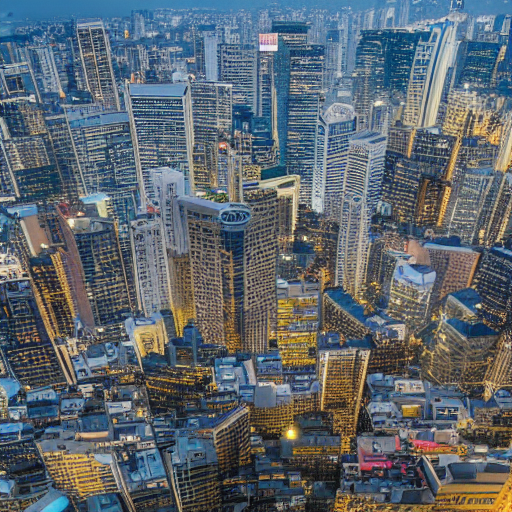

In [ ]:
from PIL import Image
import requests, io
import torch

url = "https://huggingface.co/lllyasviel/sd-controlnet-openpose/resolve/main/images/pose.png"
resp = requests.get(url)
resp.raise_for_status()
pose = Image.open(io.BytesIO(resp.content)).convert("RGB")
pose = pose.resize((512, 512))

# 3) Run your pipeline
prompt = "an image of a busy city skyline from above"
with torch.autocast("cuda"):
    out = pipe(
        prompt,
        num_inference_steps=30,
        guidance_scale=7.5,
        image=pose
    )

# 4) Show it
result = out.images[0]
display(result)

In [ ]:
import torch, gc

# clear PyTorch CUDA cache
torch.cuda.empty_cache()

# run Python GC to free up any unreferenced objects
gc.collect()

print("✅ CUDA cache cleared and garbage collected")

✅ CUDA cache cleared and garbage collected


In [ ]:
# ─── A) INSTALL (if needed) ─────────────────────────────────────────────────
!pip install -q diffusers transformers accelerate

# ─── B) IMPORTS ───────────────────────────────────────────────────────────────
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

from diffusers import (
    StableDiffusionPipeline,
    ControlNetModel,
    DDPMScheduler
)
from transformers import CLIPTokenizer, CLIPTextModel
# ─── ADD THESE IMPORTS ────────────────────────────────────────────────────────
from transformers import get_cosine_schedule_with_warmup


# ─── C) DEVICE ───────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─── D) LOAD FULL-PRECISION PIPELINE + COMPONENTS ────────────────────────────
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

# Extract and cast to float32
vae        = pipe.vae.eval().to(device).float()
unet       = pipe.unet.train().to(device).float()
tokenizer  = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_enc   = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device).float()

# Load your ControlNet-Segmentation and cast to float32
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose",
    torch_dtype=torch.float32
).to(device).float()

# Attach ControlNet to the UNet
unet.controlnet = controlnet

# ─── HYPERPARAMETERS ─────────────────────────────────────────────────────────
num_epochs    = 10
learning_rate = 1e-4
weight_decay  = 1e-6
warmup_steps  = 200

# ─── SCHEDULERS & OPTIMIZER ──────────────────────────────────────────────────
# rename the diffusion noise scheduler
noise_scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

# optimizer for ControlNet branch
optimizer = torch.optim.AdamW(
    controlnet.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# cosine‐with‐warmup LR scheduler
total_steps  = num_epochs * len(train_loader)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# ─── TRAIN + VALIDATION LOOP ─────────────────────────────────────────────────
for epoch in range(1, num_epochs + 1):
    # Training
    total_train_loss = 0.0
    unet.train()
    controlnet.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} ▶ Train"):
        # 1) Text → embeddings
        enc = tokenizer(
            batch["prompt"],
            padding="max_length", truncation=True,
            max_length=tokenizer.model_max_length,
            return_tensors="pt"
        ).to(device)
        text_embeds = text_enc(**enc).last_hidden_state

        # 2) Image → VAE latents
        imgs = (batch["image"].to(device) * 2 - 1).float()
        with torch.no_grad():
            vae_out = vae.encode(imgs)
            latents = (
                vae_out.latent_dist.sample()
                if hasattr(vae_out, "latent_dist")
                else vae_out.latents
            )
            latents = latents * vae.config.scaling_factor

        # 3) Seg → control image
        ctl = batch["mask_onehot"].argmax(1, keepdim=True).float().to(device)
        control_img = ctl.repeat(1, 3, 1, 1)

        # 4) Noise & timesteps
        noise     = torch.randn_like(latents)
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (latents.shape[0],), device=device
        )
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # 5a) ControlNet forward
        ctrl_out = controlnet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=text_embeds,
            controlnet_cond=control_img,
            return_dict=True
        )

        # 5b) UNet forward
        noise_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=text_embeds,
            down_block_additional_residuals=ctrl_out.down_block_res_samples,
            mid_block_additional_residual=ctrl_out.mid_block_res_sample,
            return_dict=False
        )[0]

        # 6) MSE loss & backward
        loss = F.mse_loss(noise_pred, noise, reduction="mean")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # step the LR scheduler

        total_train_loss += loss.item() * latents.size(0)

    avg_train = total_train_loss / len(train_loader.dataset)

    # Validation
    total_val_loss = 0.0
    unet.eval()
    controlnet.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} ▶ Val"):
            enc = tokenizer(
                batch["prompt"],
                padding="max_length", truncation=True,
                max_length=tokenizer.model_max_length,
                return_tensors="pt"
            ).to(device)
            text_embeds = text_enc(**enc).last_hidden_state

            imgs = (batch["image"].to(device) * 2 - 1).float()
            vae_out = vae.encode(imgs)
            latents = (
                vae_out.latent_dist.sample()
                if hasattr(vae_out, "latent_dist")
                else vae_out.latents
            )
            latents = latents * vae.config.scaling_factor

            ctl = batch["mask_onehot"].argmax(1, keepdim=True).float().to(device)
            control_img = ctl.repeat(1, 3, 1, 1)

            noise     = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=device
            )
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            ctrl_out = controlnet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_embeds,
                controlnet_cond=control_img,
                return_dict=True
            )
            noise_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=text_embeds,
                down_block_additional_residuals=ctrl_out.down_block_res_samples,
                mid_block_additional_residual=ctrl_out.mid_block_res_sample,
                return_dict=False
            )[0]

            val_loss = F.mse_loss(noise_pred, noise, reduction="mean")
            total_val_loss += val_loss.item() * latents.size(0)

    avg_val = total_val_loss / len(val_loader.dataset)
    current_lr = lr_scheduler.get_last_lr()[0]

    print(
        f"[Epoch {epoch}] "
        f"Train MSE: {avg_train:.6f}  |  Val MSE: {avg_val:.6f}  "
        f"|  LR: {current_lr:.2e}"
    )

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Epoch 1 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 1] Train MSE: 0.210422  |  Val MSE: 0.141938  |  LR: 2.50e-05


Epoch 2 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 2] Train MSE: 0.137495  |  Val MSE: 0.128413  |  LR: 5.00e-05


Epoch 3 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 3] Train MSE: 0.114225  |  Val MSE: 0.101099  |  LR: 7.50e-05


Epoch 4 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 4] Train MSE: 0.121063  |  Val MSE: 0.116636  |  LR: 1.00e-04


Epoch 5 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 5] Train MSE: 0.102721  |  Val MSE: 0.117884  |  LR: 9.33e-05


Epoch 6 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 6] Train MSE: 0.109516  |  Val MSE: 0.113232  |  LR: 7.50e-05


Epoch 7 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 7] Train MSE: 0.114075  |  Val MSE: 0.135970  |  LR: 5.00e-05


Epoch 8 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 8] Train MSE: 0.116669  |  Val MSE: 0.102452  |  LR: 2.50e-05


Epoch 9 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 9] Train MSE: 0.104040  |  Val MSE: 0.106706  |  LR: 6.70e-06


Epoch 10 ▶ Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 ▶ Val:   0%|          | 0/25 [00:00<?, ?it/s]

[Epoch 10] Train MSE: 0.097770  |  Val MSE: 0.106238  |  LR: 0.00e+00


Save weights for current session after training

In [ ]:
# Save the ControlNet weights you just fine-tuned
torch.save(
    controlnet.state_dict(),
    "controlnet_finetuned_segmentation.pth"
)
print("✅ Saved checkpoint: controlnet_finetuned_segmentation.pth")

✅ Saved checkpoint: controlnet_finetuned_segmentation.pth


In [ ]:
# Replace the filename below with whatever you saw from `ls`
ckpt_path = "controlnet_finetuned_segmentation.pth"
controlnet.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
print(f"✅ Loaded fine-tuned weights from {ckpt_path}")

✅ Loaded fine-tuned weights from controlnet_finetuned_segmentation.pth


Save weights for permanent sessions

In [ ]:
# 1) Mount your Drive at the top of your notebook (if you haven’t already)
from google.colab import drive
drive.mount('/content/drive')

# 2) After training, save your ControlNet weights to Drive
save_path = "/content/drive/My Drive/controlnet_finetuned_segmentation.pth"
torch.save(controlnet.state_dict(), save_path)
print(f"✅ Saved ControlNet weights to {save_path}")

# (Optional) Save the full diffusers pipeline for easy reload:
pipe_save_dir = "/content/drive/My Drive/sd_controlnet_pipeline/"
pipe.save_pretrained(pipe_save_dir)
print(f"✅ Saved full pipeline to {pipe_save_dir}")

Mounted at /content/drive
✅ Saved ControlNet weights to /content/drive/My Drive/controlnet_finetuned_segmentation.pth
✅ Saved full pipeline to /content/drive/My Drive/sd_controlnet_pipeline/


In [ ]:
# 3) Rebuild your ControlNet + SD pipeline exactly as before, but load your weights:
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline

ckpt_path = "/content/drive/My Drive/controlnet_finetuned_segmentation.pth"
# load ControlNet
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose",
    torch_dtype=torch.float32
)
controlnet.load_state_dict(torch.load(ckpt_path, map_location="cpu"))

# rebuild pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)
pipe.enable_attention_slicing()
print("✅ Pipeline reloaded with fine-tuned weights!")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Pipeline reloaded with fine-tuned weights!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Saved ADE20K mask → controlseg.png


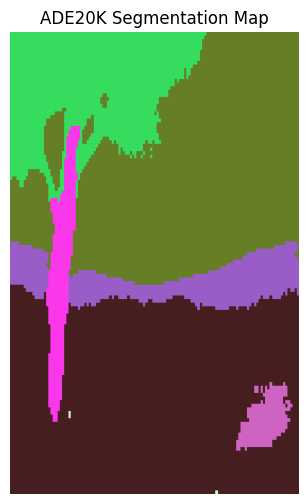

  0%|          | 0/30 [00:00<?, ?it/s]

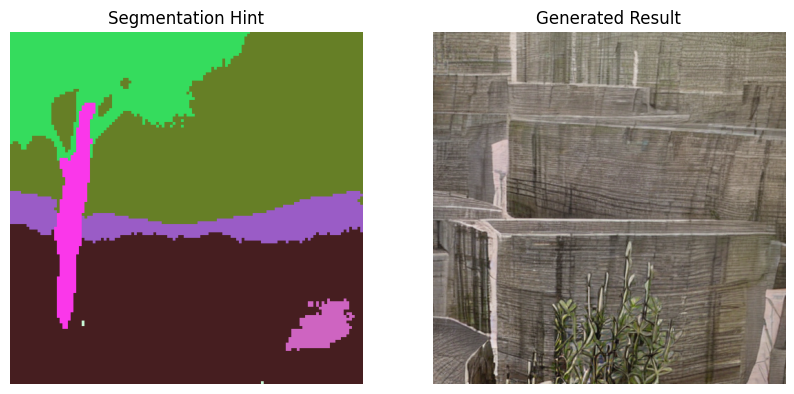

In [ ]:
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import torchvision.transforms as T
# alias for consistency
transforms = T
from torchvision.models.segmentation import deeplabv3_resnet101
from google.colab import drive
drive.mount('/content/drive')
img_path = "/content/drive/My Drive/controltest.jpg"

# 1) Rebuild pipeline (no offload + no safety)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,            # turn off NSFW filter
    torch_dtype=torch.float16
).to(device)

pipe.enable_attention_slicing()    # optional VRAM save, no offload

# Utility: convert a 2D class map into an RGB hint for ControlNet
def classmap_to_hint(class_map: np.ndarray, num_classes=150, size=(512,512)) -> Image.Image:
    rng = np.random.RandomState(1234)
    palette = rng.randint(0,256,(num_classes,3),dtype=np.uint8)
    flat = palette.flatten().tolist() + [0]*(256*3 - num_classes*3)
    pil = Image.fromarray(class_map.astype('uint8'), mode='P')
    pil.putpalette(flat)
    return pil.convert("RGB").resize(size, Image.NEAREST)

# Visualization function
def view_from_segmap(seg_path: str, prompt: str, steps=30, scale=3.0):
    """Generate and display SD output conditioned on a multi-class segmentation map."""
    mask_img = Image.open(seg_path).convert('L')
    class_map = np.array(mask_img, dtype=np.uint8)
    hint = classmap_to_hint(class_map)
    with torch.autocast(pipe.device.type):
        out = pipe(
            prompt,
            image=hint,
            num_inference_steps=steps,
            guidance_scale=scale,
            controlnet_conditioning_scale=scale
        )
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(hint)
    ax[0].set_title("Segmentation Hint")
    ax[0].axis('off')
    ax[1].imshow(out.images[0])
    ax[1].set_title("Generated Result")
    ax[1].axis('off')
    plt.show()

# --- 2) MULTI-CLASS SEGMENTATION GENERATOR -------------------------------
# --- load ADE20K SegFormer --------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
feat = SegformerFeatureExtractor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
)
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512"
).to(device)

def generate_ade20k_segmap(img_path, output_mask_path):
    img = Image.open(img_path).convert("RGB")
    # prepare inputs
    inputs = feat(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        # outputs.logits: (1, 150, H, W)
        class_map = outputs.logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
    # save P-mode mask (0–149)
    mask = Image.fromarray(class_map.astype('uint8'), mode="L")
    mask.save(output_mask_path)
    print("Saved ADE20K mask →", output_mask_path)
    # show the map alone
    # (reuse your classmap_to_hint to color it)
    hint = classmap_to_hint(class_map, num_classes=150, size=img.size[::-1])
    plt.figure(figsize=(6,6))
    plt.imshow(hint)
    plt.axis("off")
    plt.title("ADE20K Segmentation Map")
    plt.show()
    return class_map

# --- EXAMPLE FLOW: SINGLE MASK & GENERATION -------------------------------
# Step 1: Generate a segmentation mask for "input.jpg" based on your prompt
mask = generate_ade20k_segmap(
    img_path=img_path,               # your source image
    output_mask_path="controlseg.png",   # where to save the mask
)

# Step 2: Feed the generated mask into your ControlNet viewer
view_from_segmap(
    seg_path="controlseg.png",          # the mask you just saved
    prompt="a hyper-realistic image of a tree in a field",  # SD prompt
    steps=30,
    scale=3.0
)


**Experiment 1: Qualitative Analysis using FID and SSIM**




In [ ]:
# ─── INSTALL METRICS ─────────────────────────────────────────────────────────
!pip install -q torch-fidelity scikit-image

# ─── IMPORTS ─────────────────────────────────────────────────────────────────
import os, glob, random
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from torch_fidelity import calculate_metrics
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101

from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionControlNetPipeline,
    ControlNetModel
)

# ─── DEFINE SEGMENTATION HELPERS ────────────────────────────────────────────
# 1) Build your segmentation model & preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
seg_model = deeplabv3_resnet101(pretrained=True).eval().to(device)
seg_pre   = T.Compose([
    T.Resize(520),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def make_segmap(img: Image.Image):
    """Run DeepLabV3 on a PIL image, return H×W class‐ID map (0–149)."""
    inputs = feat(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    class_map = outputs.logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
    return class_map

def classmap_to_hint(class_map, num_classes=150, size=(512,512)):
    """Convert a 2D class map into an RGB hint for ControlNet."""
    rng = np.random.RandomState(1234)
    palette = rng.randint(0,256,(num_classes,3),dtype=np.uint8).reshape(-1).tolist()
    palette += [0] * (256*3 - len(palette))
    im = Image.fromarray(class_map, mode="P")
    im.putpalette(palette)
    return im.convert("RGB").resize(size, Image.NEAREST)

# ─── SETUP FOLDERS ───────────────────────────────────────────────────────────
for d in ["real", "baseline", "spade"]:
    os.makedirs(d, exist_ok=True)

# ─── 0) SELECT YOUR SAMPLES ───────────────────────────────────────────────────
local_dir = "ADEChallengeData2016/images/validation"
all_imgs  = sorted(glob.glob(os.path.join(local_dir, "*.png")) +
                   glob.glob(os.path.join(local_dir, "*.jpg")))
if len(all_imgs) < 15:
    raise RuntimeError(f"Found only {len(all_imgs)} images in {local_dir}")
samples = random.sample(all_imgs, 20)

# ─── 1) TEXT-ONLY BASELINE PIPELINE ──────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe_text = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,
).to(device)
pipe_text.enable_attention_slicing()

# ─── 2) SPADE-CONTROLNET PIPELINE ────────────────────────────────────────────
ckpt_path = "/content/drive/My Drive/controlnet_finetuned_segmentation.pth"
cn_spade = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-seg", torch_dtype=torch.float32
)
cn_spade.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
pipe_spade = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=cn_spade,
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)
pipe_spade.enable_attention_slicing()

# ─── 3) GENERATE & SAVE ─────────────────────────────────────────────────────
for i, img_path in enumerate(samples, start=1):
    img = Image.open(img_path).convert("RGB").resize((512,512), Image.LANCZOS)
    img.save(f"real/{i:02d}.png")
    prompt = "Photorealistic scene matching this ADE20K image."

    # 3a) Baseline: text only
    with torch.autocast(device):
        text_out = pipe_text(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    text_out.save(f"baseline/{i:02d}.png")

    # 3b) SPADE: segmentation + prompt
    cm   = make_segmap(img)
    hint = classmap_to_hint(cm)
    with torch.autocast(device):
        spade_out = pipe_spade(
            prompt,
            image=hint,
            num_inference_steps=50,
            guidance_scale=14.94,
            controlnet_conditioning_scale=1.0
        ).images[0]
    spade_out.save(f"spade/{i:02d}.png")

    print(f"✔ Generated sample {i:02d}")

# ─── 4) EVALUATE SSIM & FID ─────────────────────────────────────────────────
def evaluate(real_dir, gen_dir):
    ssim_scores = []
    real_paths = sorted(glob.glob(f"{real_dir}/*.png"))
    gen_paths  = sorted(glob.glob(f"{gen_dir}/*.png"))
    for r, g in zip(real_paths, gen_paths):
        a = np.array(Image.open(r).convert("RGB"))
        b = np.array(Image.open(g).convert("RGB"))
        s, _ = ssim(a, b, win_size=5, channel_axis=2, full=True)
        ssim_scores.append(s)
    mean_ssim = float(np.mean(ssim_scores))
    fid = calculate_metrics(
        input1=real_dir,
        input2=gen_dir,
        cuda=torch.cuda.is_available(),
        fid=True, isc=False, verbose=False
    )["frechet_inception_distance"]
    return mean_ssim, fid

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 01


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 02


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 03


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 04


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 05


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 06


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 07


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 08


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 09


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 10


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 11


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 12


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 13


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 14


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 15


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 16


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 17


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 18


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 19


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

✔ Generated sample 20


In [ ]:
# Run evaluation on the two pipelines you’ve generated
ssim_base, fid_base = evaluate("real", "baseline")
ssim_spade, fid_spade = evaluate("real", "spade")

print(f"Baseline → SSIM: {ssim_base:.4f}, FID: {fid_base:.4f}")
print(f"SPADE    → SSIM: {ssim_spade:.4f}, FID: {fid_spade:.4f}")

Baseline → SSIM: 0.2335, FID: 268.8445
SPADE    → SSIM: 0.2876, FID: 294.2203


**Experiment 2: Qualitative Analysis**

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✔ Saved qualitative case #1 → qualitative/case_01.png


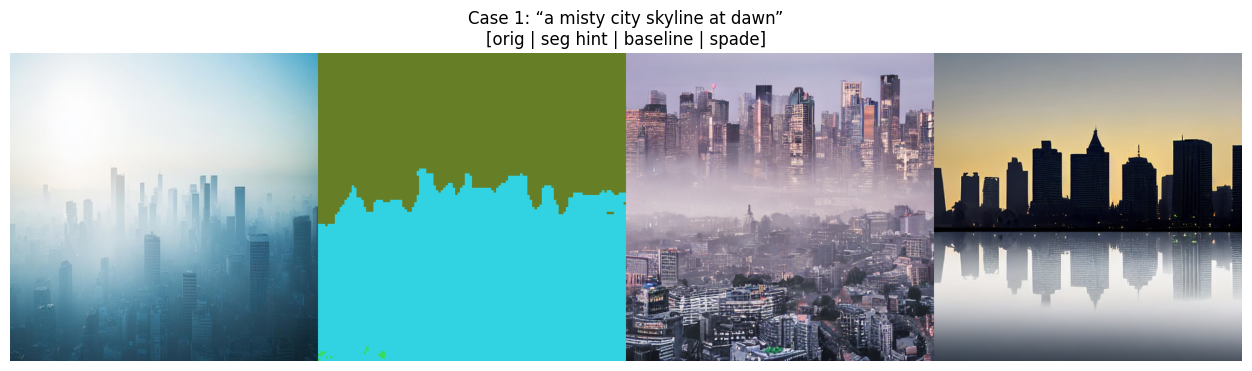

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✔ Saved qualitative case #2 → qualitative/case_02.png


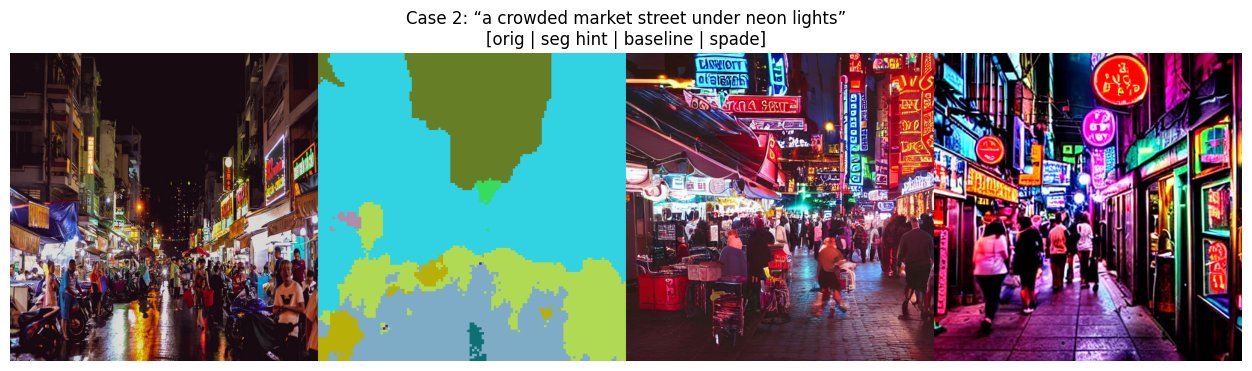

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✔ Saved qualitative case #3 → qualitative/case_03.png


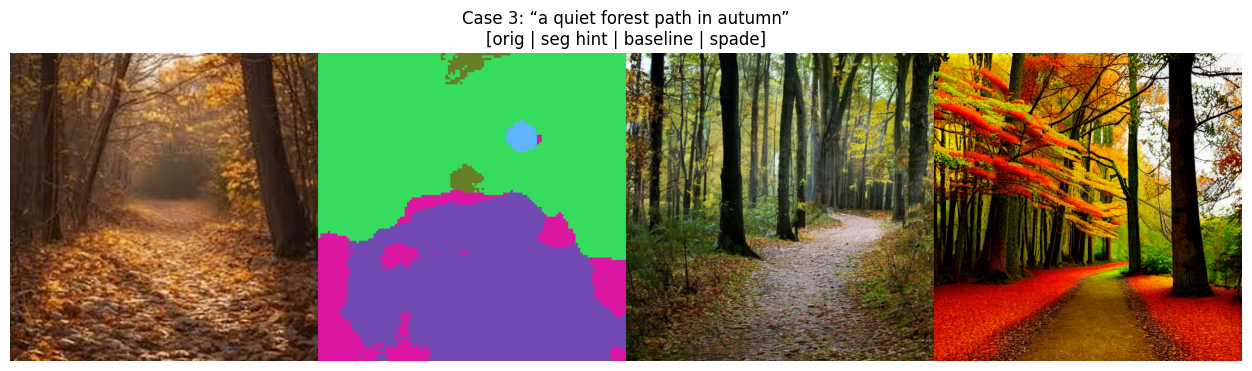

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✔ Saved qualitative case #4 → qualitative/case_04.png


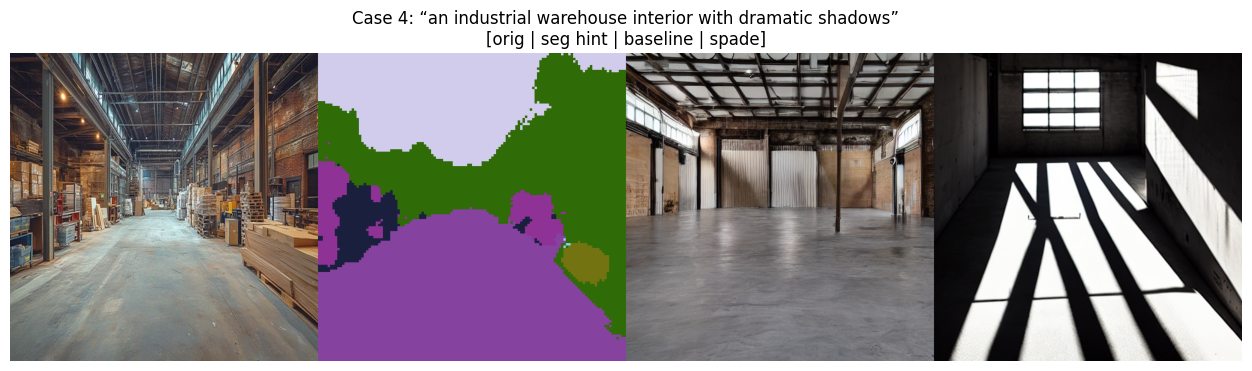

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✔ Saved qualitative case #5 → qualitative/case_05.png


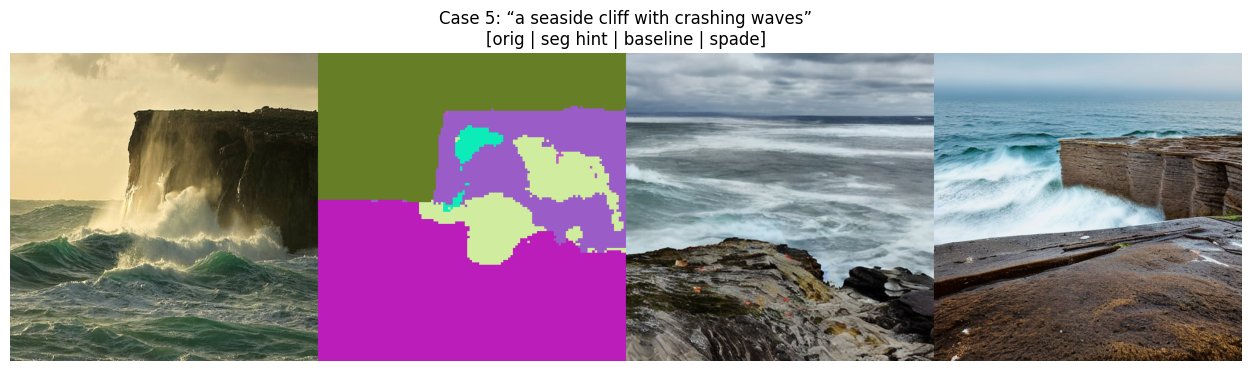

In [ ]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

# Make sure your pipelines and helpers are already in scope:
#   - make_segmap(img: Image) -> np.ndarray
#   - classmap_to_hint(class_map, …) -> PIL.Image
#   - pipe_base, pipe_spade
pipe_base = pipe_text

# 0) Prepare output folder
qual_dir = Path("qualitative")
qual_dir.mkdir(exist_ok=True)

# 1) Hand-picked test cases (you can swap in any local files)
#    Format: (path_to_image, sd_prompt)
tests = [
    ("img1.jpg", "a misty city skyline at dawn"),
    ("img2.jpeg", "a crowded market street under neon lights"),
    ("img3.jpeg", "a quiet forest path in autumn"),
    ("img4.jpg", "an industrial warehouse interior with dramatic shadows"),
    ("img5.jpg", "a seaside cliff with crashing waves"),
]

# 2) Run qualitative experiment
for i, (img_path, sd_prompt) in enumerate(tests, start=1):
    # Load original
    orig = Image.open(img_path).convert("RGB").resize((512,512), Image.LANCZOS)

    # 2a) Compute segmentation hint
    cm   = make_segmap(orig)                                   # [H,W] class IDs
    hint = classmap_to_hint(cm, size=(512,512))                # RGB hint

    # 2b) Baseline generation
    with torch.autocast(pipe_base.device.type):
        out0 = pipe_base(
            sd_prompt,
            image=hint,
            num_inference_steps=30,
            guidance_scale=3.0,
        ).images[0]

    # 2c) SPADE generation
    with torch.autocast(pipe_spade.device.type):
        out1 = pipe_spade(
            sd_prompt,
            image=hint,
            num_inference_steps=30,
            guidance_scale=14.94,
            controlnet_conditioning_scale=1.0
        ).images[0]

    # 3) Build a 1×4 collage
    w, h = orig.size
    canvas = Image.new("RGB", (w*4, h))
    canvas.paste(orig,        (0*w, 0))
    canvas.paste(hint,        (1*w, 0))
    canvas.paste(out0.resize((w,h)), (2*w, 0))
    canvas.paste(out1.resize((w,h)), (3*w, 0))

    # 4) Save & display
    save_path = qual_dir / f"case_{i:02d}.png"
    canvas.save(save_path)
    print(f"✔ Saved qualitative case #{i} → {save_path}")

    plt.figure(figsize=(16,4))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title(f"Case {i}: “{sd_prompt}”\n[orig | seg hint | baseline | spade]")
    plt.show()
